#Problem

**MNIST Dataset Neural Network Problem Description**

**The MNIST (Modified National Institute of Standards and Technology)** dataset is a classic benchmark in the field of machine learning and computer vision. It consists of 70,000 grayscale images of handwritten digits (0 through 9), each of size 28x28 pixels. The dataset is divided into 60,000 training images and 10,000 test images.

The goal of this neural network problem is to develop a model that can accurately classify the digit present in a given image. This is a multi-class classification task, where each input image is assigned one of ten possible class labels (0 to 9).

A typical solution involves designing and training a feedforward neural network or a convolutional neural network (CNN) using supervised learning. The model learns to recognize patterns and features in the digit images that are predictive of their respective labels.

**Problem Type**: Image Classification (Supervised Learning)\
**Input**: 28x28 grayscale image (784 features when flattened)\
**Output**: Digit labels from 0 to 9\
**Objective**: Maximize classification accuracy on the test set

Special thanks to channels:\
https://www.youtube.com/@3blue1brown \
https://www.youtube.com/@SamsonZhangTheSalmon

### On Page Explanation

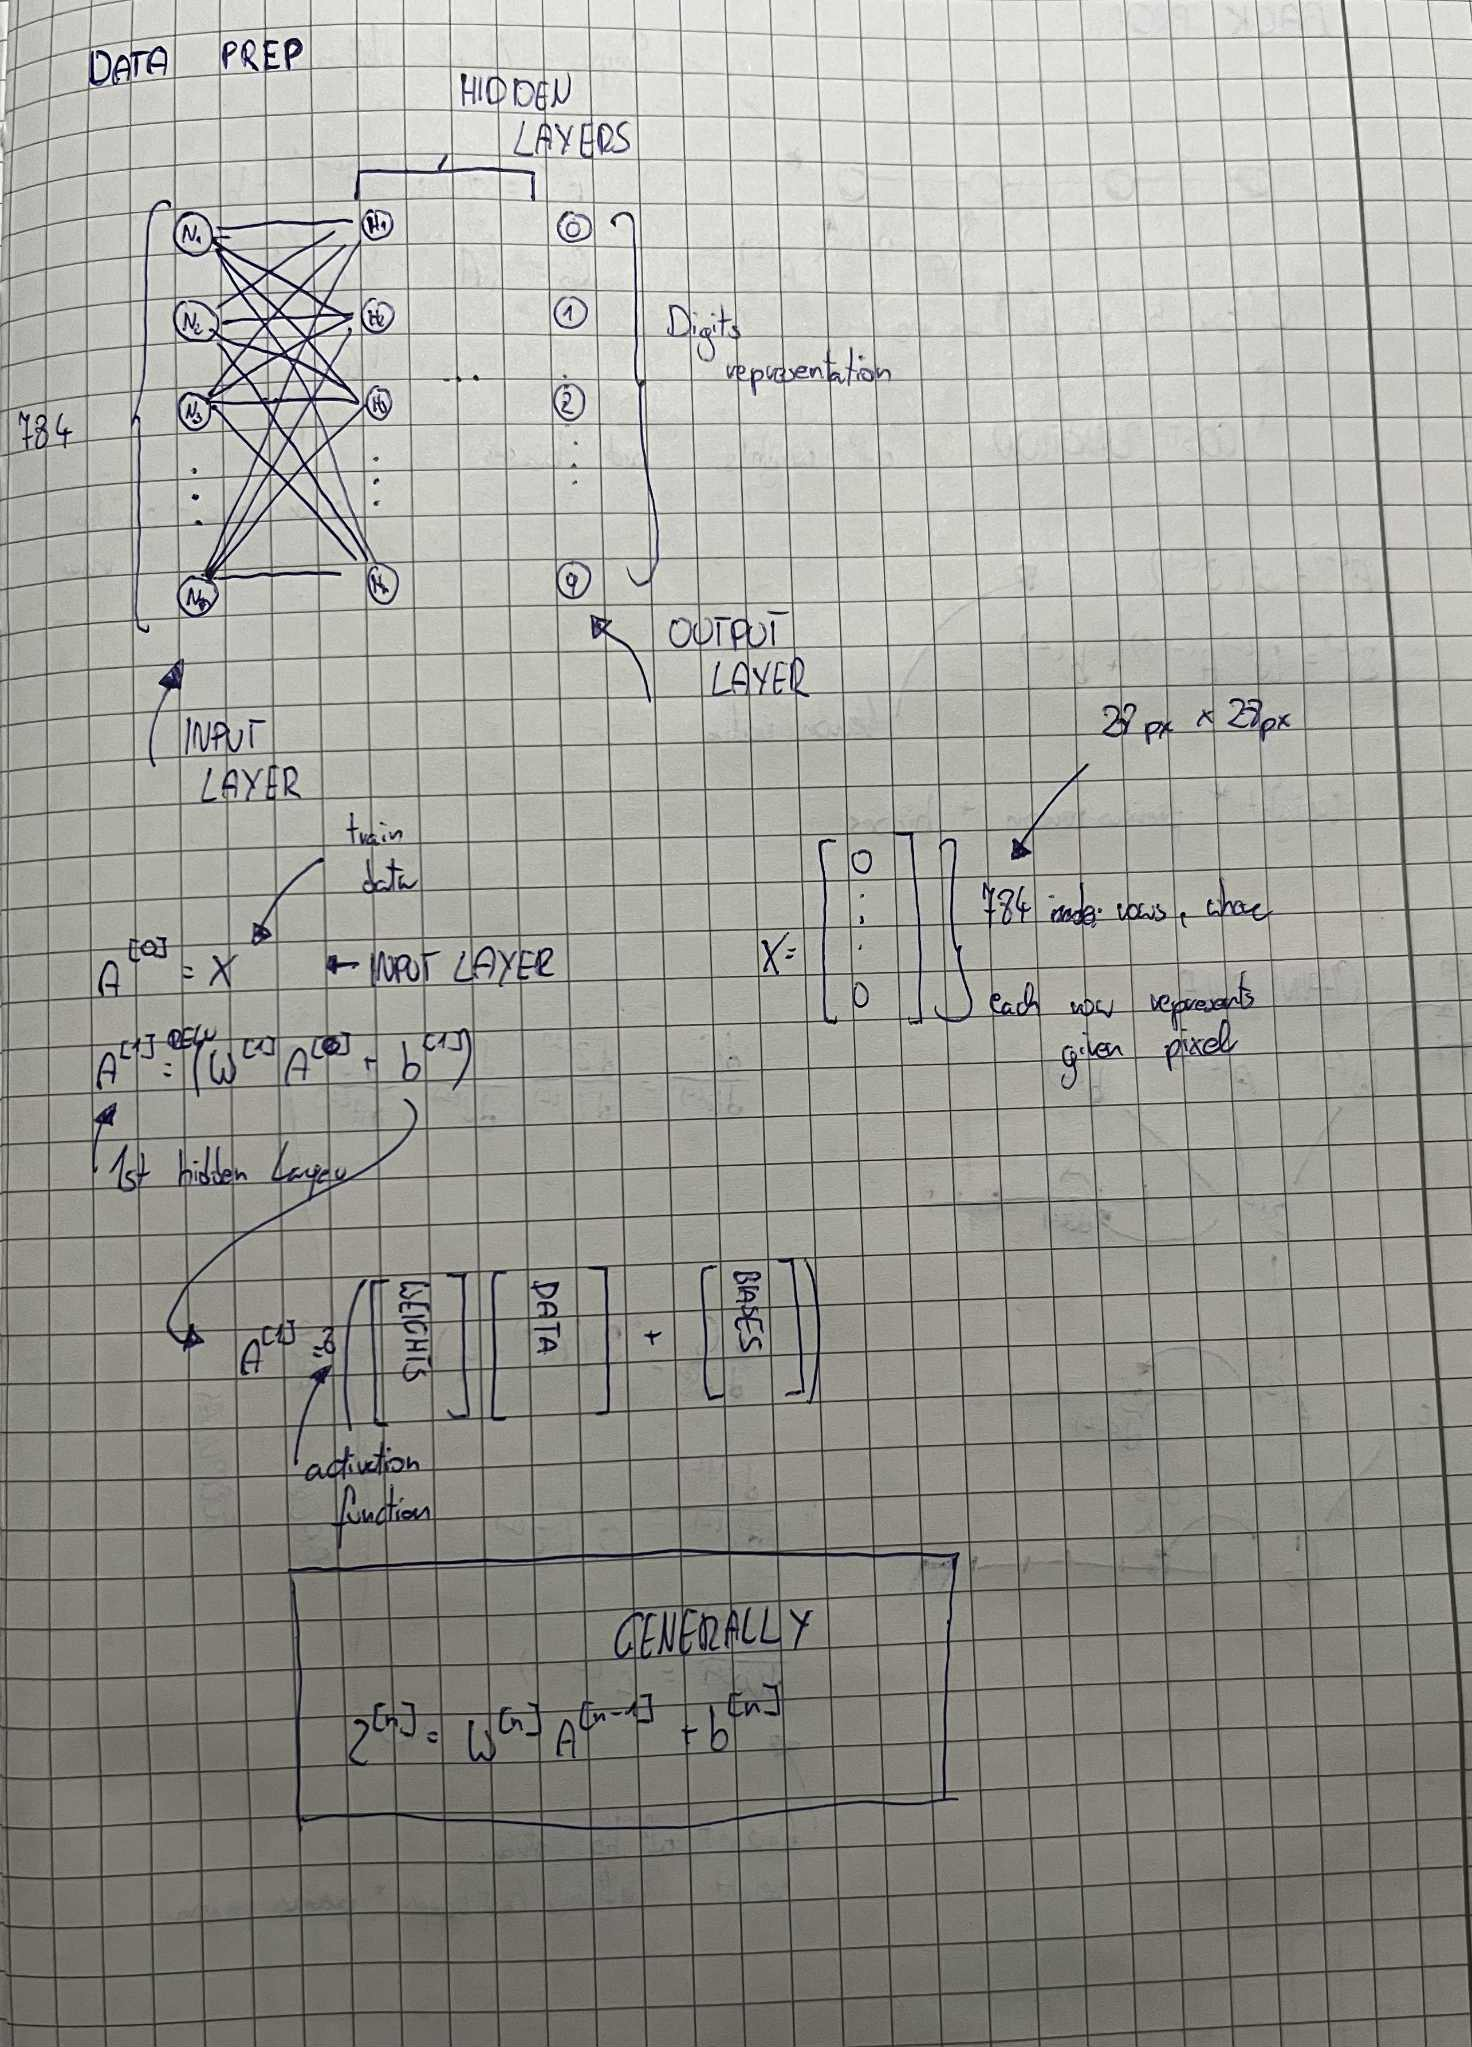

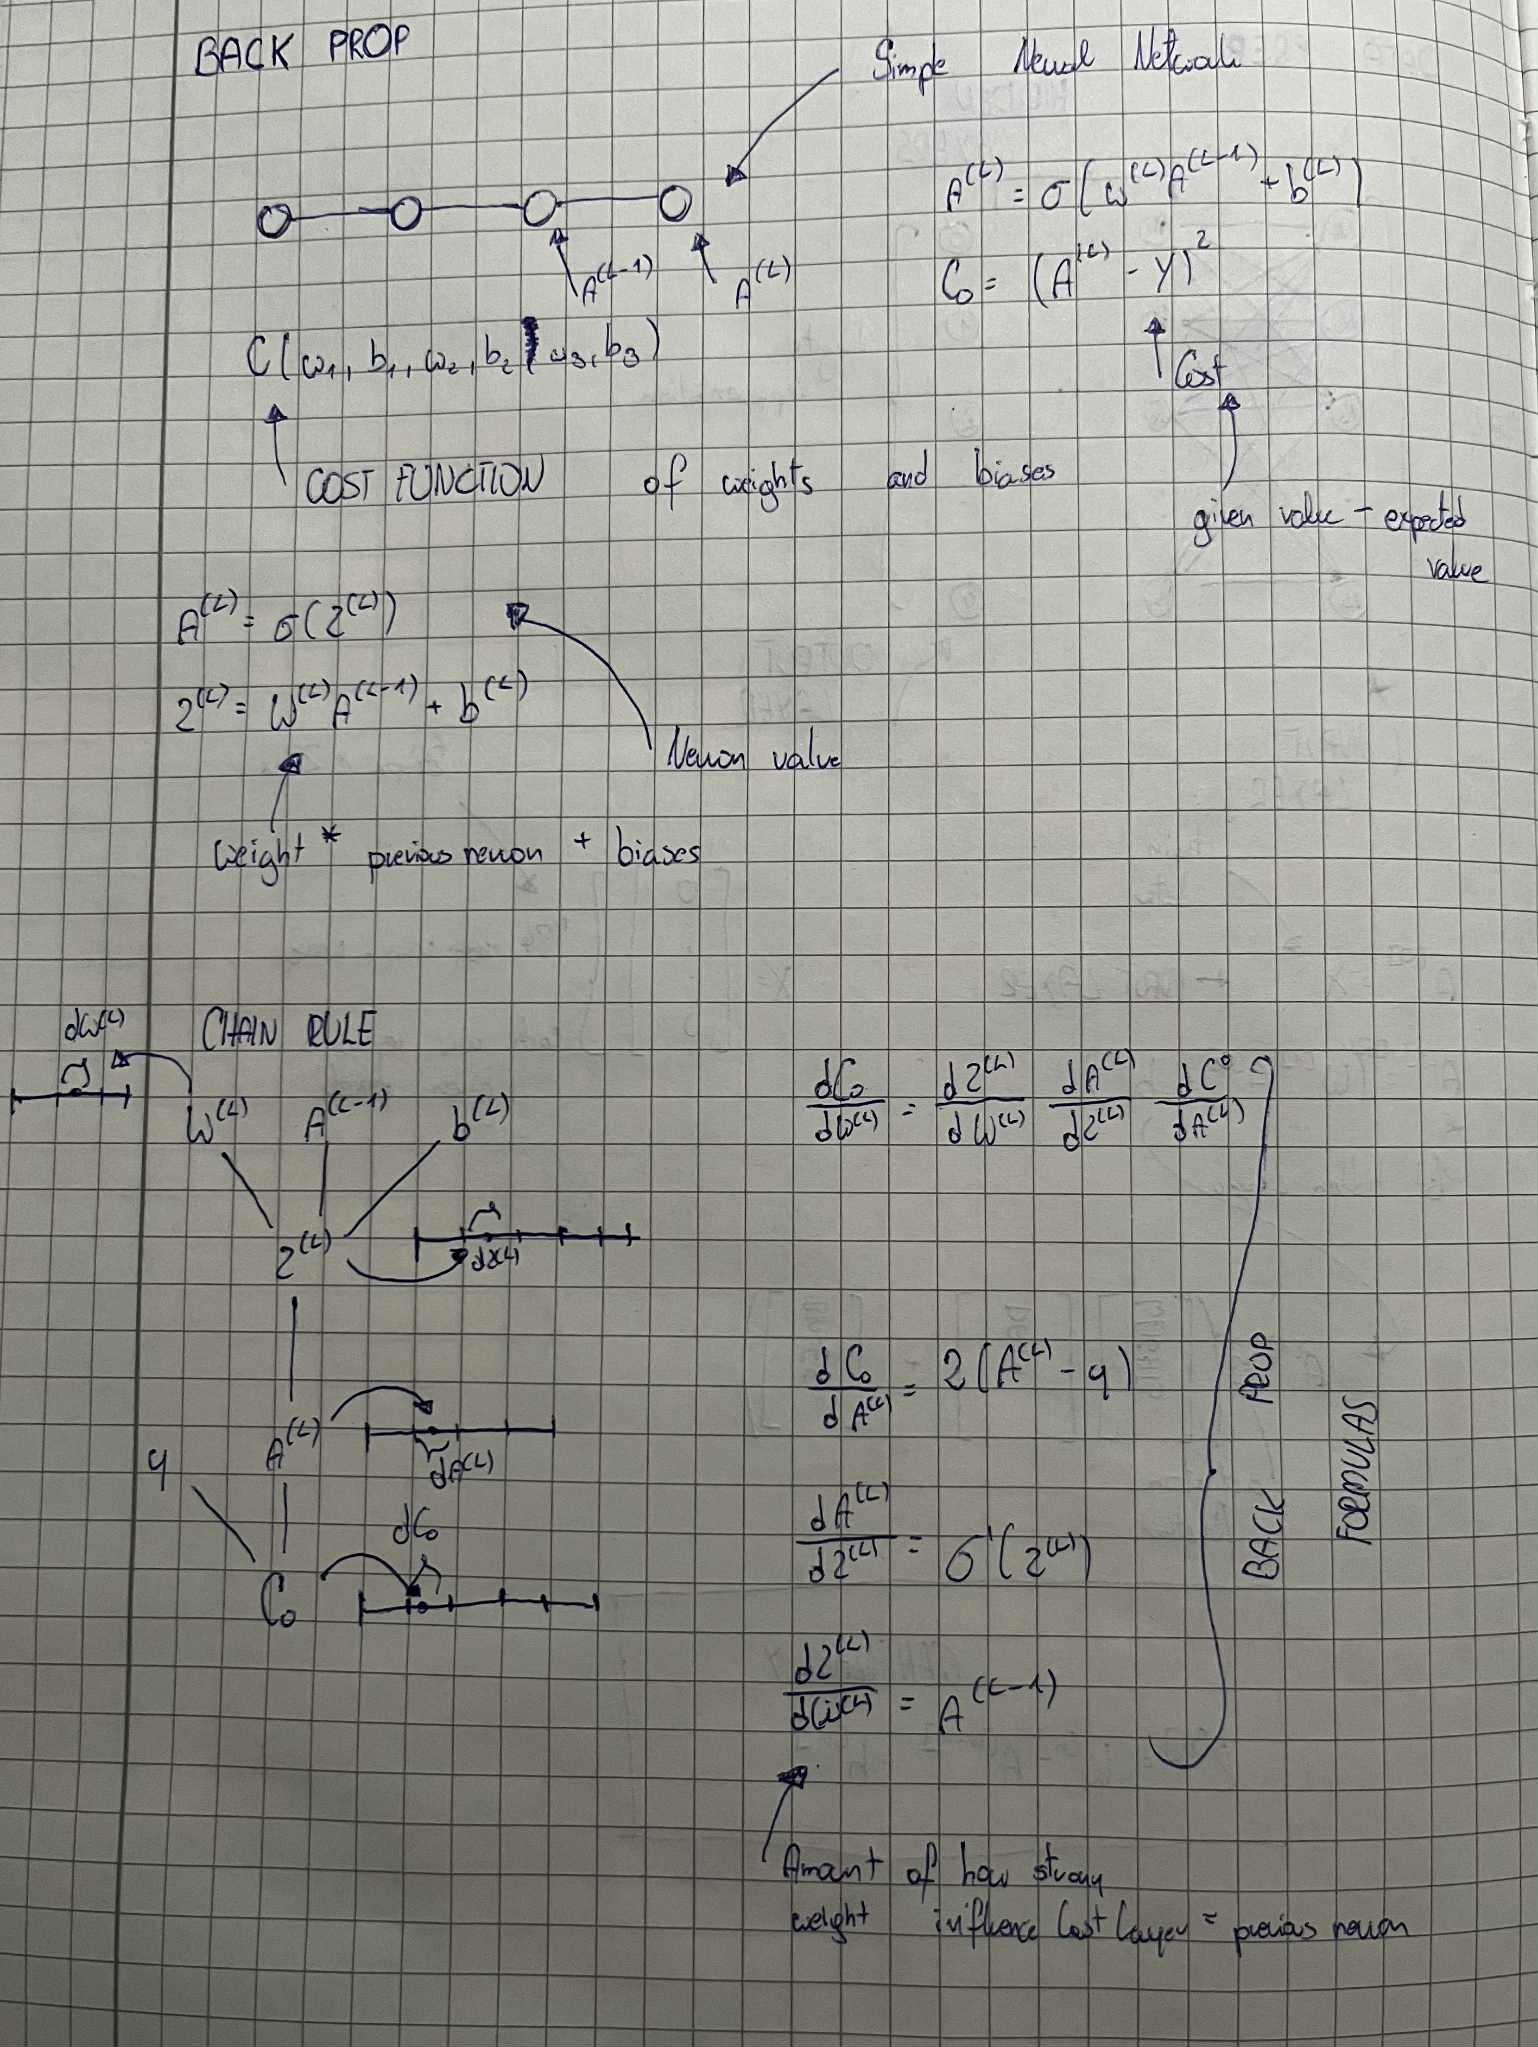

In [63]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from typing import Tuple, TypeAlias
from numpy.typing import NDArray
import tensorflow as tf
from tensorflow.keras import layers, models

# Data prep

In [64]:
MNIST_PATH: str = '/content/sample_data/mnist_test.csv'
SAMPLE_SIZE: int = 5

In [65]:
mnist_df = pd.read_csv(MNIST_PATH)
mnist_df.sample(SAMPLE_SIZE)

,7,0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,...,0.658,0.659,0.660,0.661,0.662,0.663,0.664,0.665,0.666,0.667
9436,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9508,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1584,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
867,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1498,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [66]:
data = np.array(mnist_df)
data

array([[2, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [4, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0],
       [6, 0, 0, ..., 0, 0, 0]])

In [67]:
# row - amount of rows
# features - amount of features + 1
row, features = data.shape
np.random.shuffle(data)

# Data for testing
data_dev = data[0:1000].T
Y_dev = data_dev[0] # First row
X_dev = data_dev[1:features]
X_dev = X_dev / 255. # Normalization for pixels

# Data for training
data_train = data[1000:row].T
Y_train = data_train[0]
X_train = data_train[1:features]
X_train = X_train / 255. # Normalization for pixels
_,m_train = X_train.shape

In [68]:
# Training data, where each column consist of 784 pixels
# Each pixel is represented by a value that determines, how white is that pixel
X_train.shape

(784, 8999)

In [69]:
# Labels
Y_train

array([1, 1, 4, ..., 2, 4, 8])

# Implementation From Scratch

### Forward Prop

In [70]:
# Type for returning 4 NDArrays
Quad: TypeAlias = Tuple[NDArray[np.floating], NDArray[np.floating], NDArray[np.floating], NDArray[np.floating]]

def init_params() -> Quad:
    """
    Initialize neural network parameters with proper scaling.

    Use smaller random values to prevent gradient explosion/vanishing.
    The scaling factor 0.1 helps with initial convergence.
    """
    # Weights for the 1st hidden layer - smaller initialization
    W1 = np.random.randn(10, 784) * 0.1
    # Biases for the 1st hidden layer - start with zeros
    b1 = np.zeros((10, 1))
    # Weights for the 2nd hidden layer - smaller initialization
    W2 = np.random.randn(10, 10) * 0.1
    # Biases for the 2nd hidden layer - start with zeros
    b2 = np.zeros((10, 1))
    return W1, b1, W2, b2

In [71]:
def ReLu(Z: np.array) -> np.maximum:
    """
    ReLU (Rectified Linear Unit) activation function.

    ReLU is defined as:
    f(x) = max(0, x)

    Properties:
    - Returns 0 for negative inputs (kills negative signals)
    - Returns the input value for positive inputs (linear for positive values)
    - Helps with vanishing gradient problem
    - Computationally efficient
    - Introduces non-linearity to the network

    Args:
        Z: Pre-activation values (linear combination W*X + b)

    Returns:
        Element-wise maximum between 0 and input values
    """
    return np.maximum(0, Z)

def Softmax(Z: np.array) -> np.floating:
    """
    Numerically stable Softmax activation function for multi-class classification.

    This version subtracts the maximum value to prevent overflow.
    Works correctly for batched data (multiple samples).
    """
    # Subtract max for numerical stability
    # keepdims=True maintains the shape for broadcasting
    Z_stable = Z - np.max(Z, axis=0, keepdims=True)
    exp_Z = np.exp(Z_stable)
    return exp_Z / np.sum(exp_Z, axis=0, keepdims=True)

def forward_prop(W1, b1, W2, b2, X) -> Quad:
    """
    Perform forward propagation through a 2-layer neural network.

    Network Architecture:
    Input Layer -> Hidden Layer (ReLU) -> Output Layer (Softmax)

    The forward pass computes predictions by:
    1. Linear transformation: Z = W*X + b
    2. Non-linear activation: A = activation(Z)
    3. Repeat for each layer

    Mathematical Flow:
    X -> Z1 = W1*X + b1 -> A1 = ReLU(Z1) -> Z2 = W2*A1 + b2 -> A2 = Softmax(Z2)

    Args:
        W1: Weight matrix for hidden layer, shape (hidden_units, input_features)
        b1: Bias vector for hidden layer, shape (hidden_units, 1)
        W2: Weight matrix for output layer, shape (output_classes, hidden_units)
        b2: Bias vector for output layer, shape (output_classes, 1)
        X: Input features, shape (input_features, num_samples)

    Returns:
        Tuple containing intermediate values needed for backpropagation:
        - Z1: Pre-activation values of hidden layer
        - A1: Post-activation values of hidden layer (ReLU output)
        - Z2: Pre-activation values of output layer
        - A2: Post-activation values of output layer (Softmax probabilities)
    """

    # === HIDDEN LAYER COMPUTATION ===
    # Linear transformation: combine inputs with learned weights and biases
    # Z1 shape: (hidden_units, num_samples)
    Z1 = W1.dot(X) + b1

    # Apply ReLU activation function element-wise
    # This introduces non-linearity, allowing the network to learn complex patterns
    # A1 shape: (hidden_units, num_samples)
    A1 = ReLu(Z1)

    # === OUTPUT LAYER COMPUTATION ===
    # Linear transformation using hidden layer output as input
    # Z2 shape: (output_classes, num_samples)
    Z2 = W2.dot(A1) + b2

    # Apply Softmax activation to get class probabilities
    # Each column sums to 1, representing probability distribution over classes
    # A2 shape: (output_classes, num_samples)
    A2 = Softmax(Z2)

    # Return all intermediate values for use in backpropagation
    # These cached values avoid recomputing during backward pass
    return Z1, A1, Z2, A2

### Back Prop

In [72]:
def ReLU_deriv(Z):
    """
    Compute the derivative of the ReLU activation function.

    ReLU derivative is:
    - 1 if Z > 0 (function is active/linear region)
    - 0 if Z <= 0 (function is inactive/dead region)

    Args:
        Z: Input values (pre-activation)

    Returns:
        Boolean array that gets converted to 1s and 0s
    """
    return Z > 0

def one_hot(Y) -> NDArray[np.floating]:
    """
    Convert class labels to one-hot encoded matrix.

    For a classification problem with C classes, each label becomes
    a vector of length C with 1 at the correct class position and 0s elsewhere.

    Example: If Y = [1, 0, 2] with 3 classes:
    Result = [[0, 1, 0],  # Class 1
              [1, 0, 0],  # Class 0
              [0, 0, 1]]  # Class 2

    Args:
        Y: Array of class labels (integers)

    Returns:
        One-hot encoded matrix of shape (num_classes, num_samples)
    """
    # Create matrix of zeros with shape (num_samples, num_classes)
    one_hot_Y = np.zeros((Y.size, Y.max() + 1))

    # Set the appropriate positions to 1 using advanced indexing
    # np.arange(Y.size) creates [0, 1, 2, ...] for row indices
    # Y contains the column indices (class labels)
    one_hot_Y[np.arange(Y.size), Y] = 1

    # Transpose to get shape (num_classes, num_samples) for matrix operations
    return one_hot_Y.T

def backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y) -> Quad:
    """
    Perform backpropagation to compute gradients for a 2-layer neural network.

    FIXED: Now properly calculates the number of samples and handles bias gradients.
    """
    # Get the number of training samples
    m = Y.size

    # Convert labels to one-hot encoding for loss computation
    one_hot_Y = one_hot(Y)

    # === OUTPUT LAYER GRADIENTS ===
    dZ2 = A2 - one_hot_Y

    # Gradient w.r.t. output layer weights
    dW2 = (1 / m) * dZ2.dot(A1.T)

    # Gradient w.r.t. output layer bias - sum along sample axis
    db2 = (1 / m) * np.sum(dZ2, axis=1, keepdims=True)

    # === HIDDEN LAYER GRADIENTS ===
    dZ1 = W2.T.dot(dZ2) * ReLU_deriv(Z1)

    # Gradient w.r.t. hidden layer weights
    dW1 = (1 / m) * dZ1.dot(X.T)

    # Gradient w.r.t. hidden layer bias - sum along sample axis
    db1 = (1 / m) * np.sum(dZ1, axis=1, keepdims=True)

    return dW1, db1, dW2, db2

def update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha) -> Quad:
    """
    Update neural network parameters using gradient descent.

    Gradient descent update rule:
    parameter = parameter - learning_rate * gradient

    This moves parameters in the direction opposite to the gradient,
    which should decrease the loss function.

    Args:
        W1, b1: Current weights and biases for hidden layer
        W2, b2: Current weights and biases for output layer
        dW1, db1, dW2, db2: Computed gradients from backpropagation
        alpha: Learning rate (controls step size)

    Returns:
        Updated parameters: (W1, b1, W2, b2)
    """
    # Update hidden layer parameters
    W1 = W1 - alpha * dW1  # Update hidden layer weights
    b1 = b1 - alpha * db1  # Update hidden layer bias

    # Update output layer parameters
    W2 = W2 - alpha * dW2  # Update output layer weights
    b2 = b2 - alpha * db2  # Update output layer bias

    return W1, b1, W2, b2

### Training

In [73]:
def get_predictions(A2):
    """
    Convert softmax probabilities to predicted class labels.

    The softmax output gives us probabilities for each class.
    We take the class with the highest probability as our prediction.

    Example:
    If A2 = [[0.1, 0.7, 0.2],   # Sample 1: probabilities for classes 0,1,2
             [0.8, 0.1, 0.1],   # Sample 2: probabilities for classes 0,1,2
             [0.3, 0.2, 0.5]]   # Sample 3: probabilities for classes 0,1,2

    Result = [1, 0, 2]  # Predicted classes (highest probability indices)

    Args:
        A2: Softmax output probabilities, shape (num_classes, num_samples)
            Each column represents probability distribution for one sample

    Returns:
        Array of predicted class indices, shape (num_samples,)
    """
    # np.argmax finds the index of maximum value along specified axis
    # axis=0 means find max along rows (across classes for each sample)
    return np.argmax(A2, 0)

def get_accuracy(predictions, Y):
    """
    Calculate classification accuracy by comparing predictions to true labels.

    Accuracy = (Number of correct predictions) / (Total number of predictions)

    This is a simple metric that works well for balanced datasets.
    For imbalanced datasets, consider using precision, recall, or F1-score.

    Args:
        predictions: Predicted class labels, shape (num_samples,)
        Y: True class labels, shape (num_samples,)

    Returns:
        Accuracy as a float between 0 and 1 (multiply by 100 for percentage)
    """
    # Debug print to see predictions vs actual labels
    print(predictions, Y)

    # Element-wise comparison: predictions == Y gives boolean array
    # np.sum counts True values (correct predictions)
    # Divide by total number of samples to get accuracy percentage
    return np.sum(predictions == Y) / Y.size

def gradient_descent(X, Y, alpha, iterations):
    """
    Train the neural network using gradient descent optimization.

    Gradient descent is an iterative optimization algorithm that:
    1. Computes the loss gradient with respect to parameters
    2. Updates parameters in the direction that reduces loss
    3. Repeats until convergence or max iterations reached

    Training Process:
    - Forward pass: compute predictions and loss
    - Backward pass: compute gradients via backpropagation
    - Parameter update: apply gradient descent step
    - Repeat and monitor progress

    Args:
        X: Training features, shape (num_features, num_samples)
        Y: Training labels, shape (num_samples,)
        alpha: Learning rate - controls step size in parameter updates
               - Too large: may overshoot optimal values, cause instability
               - Too small: slow convergence, may get stuck in local minima
        iterations: Number of training epochs/iterations

    Returns:
        Tuple of trained parameters: (W1, b1, W2, b2)
    """
    # Initialize network parameters (weights and biases) randomly
    # Good initialization is crucial for successful training
    W1, b1, W2, b2 = init_params()

    # Training loop - iterate through specified number of epochs
    for i in range(iterations):

        # === FORWARD PROPAGATION ===
        # Compute predictions and cache intermediate values for backprop
        Z1, A1, Z2, A2 = forward_prop(W1, b1, W2, b2, X)

        # === BACKWARD PROPAGATION ===
        # Compute gradients of loss function w.r.t. all parameters
        # Uses chain rule to propagate error from output back to input
        dW1, db1, dW2, db2 = backward_prop(Z1, A1, Z2, A2, W1, W2, X, Y)

        # === PARAMETER UPDATE ===
        # Apply gradient descent: move parameters in direction of negative gradient
        # This should decrease the loss function value
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, dW1, db1, dW2, db2, alpha)

        # === PROGRESS MONITORING ===
        # Every 10 iterations, print current performance metrics
        # This helps monitor training progress and detect issues early
        if i % 10 == 0:
            print("Iteration: ", i)

            # Get current predictions from latest forward pass
            predictions = get_predictions(A2)

            # Calculate and print current accuracy
            # Accuracy should generally increase over time if training is working
            accuracy = get_accuracy(predictions, Y)
            print(f"Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    # Return the trained parameters for making predictions on new data
    return W1, b1, W2, b2

In [74]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, alpha=0.1, iterations=1000)

Iteration:  0
[2 1 2 ... 2 1 1] [1 1 4 ... 2 4 8]
Accuracy: 0.1258 (12.58%)
Iteration:  10
[1 1 2 ... 2 1 0] [1 1 4 ... 2 4 8]
Accuracy: 0.2237 (22.37%)
Iteration:  20
[1 1 2 ... 2 1 8] [1 1 4 ... 2 4 8]
Accuracy: 0.3100 (31.00%)
Iteration:  30
[1 1 4 ... 2 1 8] [1 1 4 ... 2 4 8]
Accuracy: 0.3763 (37.63%)
Iteration:  40
[1 1 7 ... 2 1 8] [1 1 4 ... 2 4 8]
Accuracy: 0.4724 (47.24%)
Iteration:  50
[1 1 7 ... 2 2 8] [1 1 4 ... 2 4 8]
Accuracy: 0.5733 (57.33%)
Iteration:  60
[1 1 7 ... 2 2 8] [1 1 4 ... 2 4 8]
Accuracy: 0.6402 (64.02%)
Iteration:  70
[1 1 7 ... 2 2 8] [1 1 4 ... 2 4 8]
Accuracy: 0.6886 (68.86%)
Iteration:  80
[1 1 7 ... 2 2 8] [1 1 4 ... 2 4 8]
Accuracy: 0.7303 (73.03%)
Iteration:  90
[1 1 7 ... 2 8 8] [1 1 4 ... 2 4 8]
Accuracy: 0.7534 (75.34%)
Iteration:  100
[1 1 7 ... 2 8 8] [1 1 4 ... 2 4 8]
Accuracy: 0.7730 (77.30%)
Iteration:  110
[1 1 7 ... 2 8 8] [1 1 4 ... 2 4 8]
Accuracy: 0.7883 (78.83%)
Iteration:  120
[1 1 7 ... 2 8 8] [1 1 4 ... 2 4 8]
Accuracy: 0.8012 (80.12

# Testing Solution

In [75]:
def make_predictions(X: np.ndarray, W1: np.ndarray, b1: np.ndarray,
                     W2: np.ndarray, b2: np.ndarray) -> np.ndarray:
    """
    Perform a forward pass through the neural network and return predictions.

    Parameters:
        X (np.ndarray): Input data of shape (input_size, number_of_examples).
        W1 (np.ndarray): Weights for the first layer.
        b1 (np.ndarray): Biases for the first layer.
        W2 (np.ndarray): Weights for the second layer.
        b2 (np.ndarray): Biases for the second layer.

    Returns:
        np.ndarray: Predicted class labels for the input data.
    """
    _, _, _, A2 = forward_prop(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index: int, W1: np.ndarray, b1: np.ndarray,
                    W2: np.ndarray, b2: np.ndarray) -> None:
    """
    Display a test image from the training set and print its predicted and true label.

    Parameters:
        index (int): Index of the sample to test from X_train.
        W1 (np.ndarray): Weights for the first layer.
        b1 (np.ndarray): Biases for the first layer.
        W2 (np.ndarray): Weights for the second layer.
        b2 (np.ndarray): Biases for the second layer.
    """
    current_image = X_train[:, index, None]
    prediction = make_predictions(X_train[:, index, None], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()


Prediction:  [1]
Label:  1


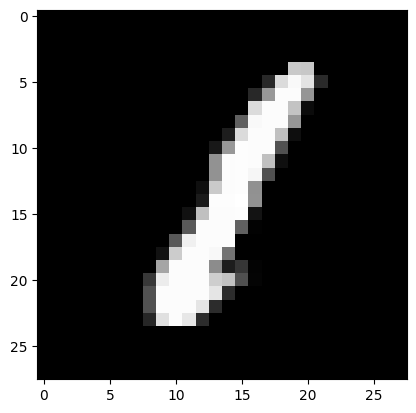

Prediction:  [1]
Label:  1


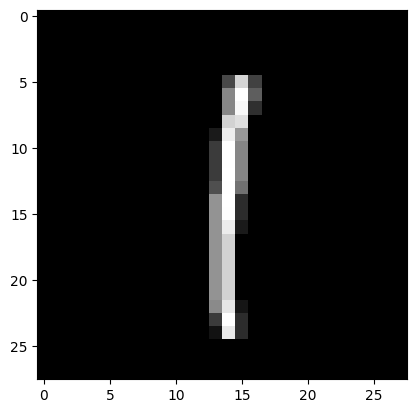

Prediction:  [4]
Label:  4


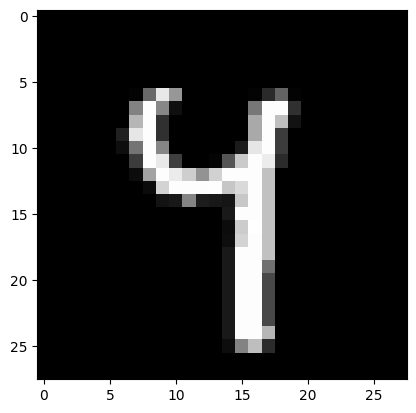

Prediction:  [5]
Label:  5


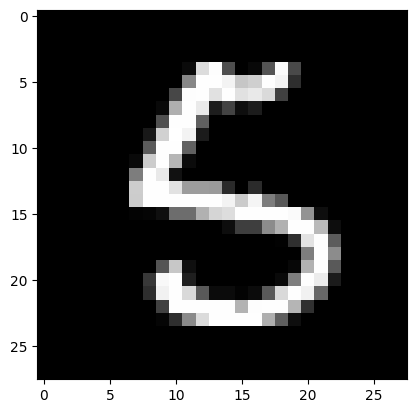

In [76]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

# Implementation using TensorFlow

In [77]:
# Load and preprocess the MNIST dataset
def load_and_preprocess_data() -> Tuple[Tuple[tf.Tensor, tf.Tensor], Tuple[tf.Tensor, tf.Tensor]]:
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

    # Normalize the images to [0, 1] range
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    # Flatten the 28x28 images to 784-dimensional vectors
    x_train = x_train.reshape((-1, 28 * 28))
    x_test = x_test.reshape((-1, 28 * 28))

    return (x_train, y_train), (x_test, y_test)

# Define the model architecture
def build_model(input_shape: int = 784, num_classes: int = 10) -> tf.keras.Model:
    model = models.Sequential([
        layers.Input(shape=(input_shape,)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(num_classes, activation='softmax')  # Output layer for 10 classes
    ])
    return model

# Compile and train the model
def train_model(model: tf.keras.Model,
                x_train: tf.Tensor, y_train: tf.Tensor,
                x_val: tf.Tensor, y_val: tf.Tensor,
                epochs: int = 5, batch_size: int = 32) -> tf.keras.callbacks.History:
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    return history

# Evaluate the model on test data
def evaluate_model(model: tf.keras.Model, x_test: tf.Tensor, y_test: tf.Tensor) -> None:
    test_loss, test_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {test_accuracy:.4f}")
    print(f"Test loss: {test_loss:.4f}")

In [78]:
(x_train, y_train), (x_test, y_test) = load_and_preprocess_data()
model = build_model()
train_model(model, x_train, y_train, x_test, y_test)
evaluate_model(model, x_test, y_test)

Epoch 1/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 5ms/step - accuracy: 0.8779 - loss: 0.4249 - val_accuracy: 0.9597 - val_loss: 0.1265
Epoch 2/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 5ms/step - accuracy: 0.9664 - loss: 0.1130 - val_accuracy: 0.9656 - val_loss: 0.1074
Epoch 3/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9773 - loss: 0.0721 - val_accuracy: 0.9745 - val_loss: 0.0842
Epoch 4/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 18s 5ms/step - accuracy: 0.9842 - loss: 0.0504 - val_accuracy: 0.9770 - val_loss: 0.0752
Epoch 5/5
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.9873 - loss: 0.0400 - val_accuracy: 0.9759 - val_loss: 0.0806
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9745 - loss: 0.0887
Test accuracy: 0.9759
Test loss: 0.0806
